# Fourier state preparation

Here we introduce the Fourier block encoding class and show how it can be used within LCUStatePreparationBox to implement simple linear combinations of Fourier basis elements.

In [3]:
import numpy as np
from pytket.extensions.qiskit import AerStateBackend
from pytket.circuit.display import render_circuit_jupyter
from matplotlib import pyplot as plt

from qtmlib.utils.linalg_utils import get_projector_matrix
from qtmlib.circuits.lcu_state_preparation.lcu_state_preparation_block_encoding import FourierBlockEncoding
from qtmlib.circuits.lcu_state_preparation.lcu_state_preparation import LCUStatePreparationBox

We create a FourierBlockEncoding for `n_qubits = 5` qubits. The method generate_basis_elements creates a RegisterBox implementing the Fourier element of order `fourier_index` as a block encoding.

In [4]:
n_qubits = 5

W = FourierBlockEncoding(n_block_qubits=n_qubits)
W_box = W.generate_basis_element(basis_index=1)

We visualise the circuit.

In [5]:
render_circuit_jupyter(W_box.reg_circuit)

We create the first five Fourier elements and plot them.

In [6]:
def evaluate_block_encoding(state_qubits, index=1):
    n_state_qubits = len(state_qubits)
    
    W_box = FourierBlockEncoding(n_block_qubits=n_state_qubits).generate_basis_element(basis_index=index)
    unitary = W_box.get_circuit().get_unitary()    
    
    return unitary.diagonal()

In [7]:
W_box.q_registers

[QubitRegister("block", 5)]

In [8]:
state_qubits = W_box.q_registers[0]

evaluations = []
for i in range(5):
    evaluations.append(evaluate_block_encoding(state_qubits, i))
    

Let's plot them.

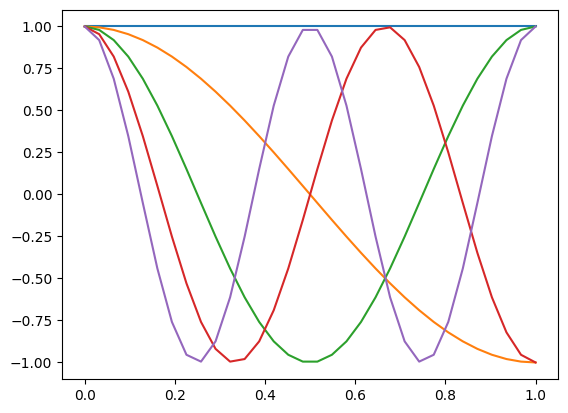

In [9]:
for eval in evaluations:
    plt.plot(np.linspace(0,1,len(eval.real)), eval.real)

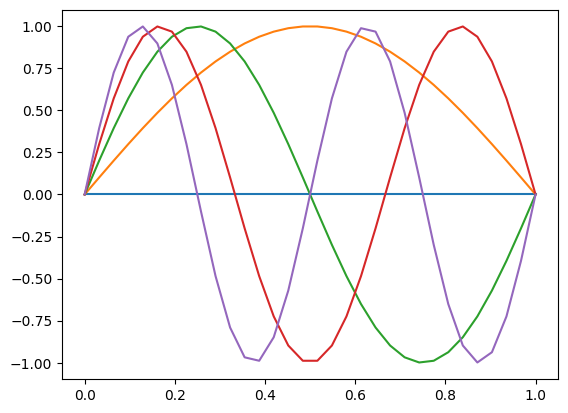

In [10]:
for eval in evaluations:
    plt.plot(np.linspace(0,1,len(eval.imag)), eval.imag)

Looks good.

## Full state preparation circuit

Here we use the Fourier block encoding in combination with the LCUStatePreparationBox to prepare a simple linear combination of Fourier elements.

In [11]:
n_qubits = 8

W = FourierBlockEncoding(n_block_qubits=n_qubits)

dims_fourier_variables = (8,)
dims_variables = (2**n_qubits,)

coeffs = np.zeros(4)
coeffs[1] = 0.5
coeffs[3] = 0.7

In [12]:
lcuspbox = LCUStatePreparationBox(
    coeffs,
    [W],
)

The circuit looks like...

In [13]:
render_circuit_jupyter(lcuspbox.reg_circuit)

We get the statevector from noiseless simulation and projecting to the all-zero state in the ancilla registers.

In [14]:
backend = AerStateBackend()
circ_compiled = backend.get_compiled_circuit(lcuspbox.get_circuit(), optimisation_level=0)
vec = backend.run_circuit(circ_compiled).get_state()

n_qubits_state = lcuspbox.n_qubits_state[0]
n_qubits_fourier = lcuspbox.n_qubits_coeffs[0]

projector = np.array(get_projector_matrix(list(range(n_qubits_fourier)), list(range(n_qubits_fourier, n_qubits_fourier + n_qubits_state))))
vec_projected = projector.transpose() @ vec

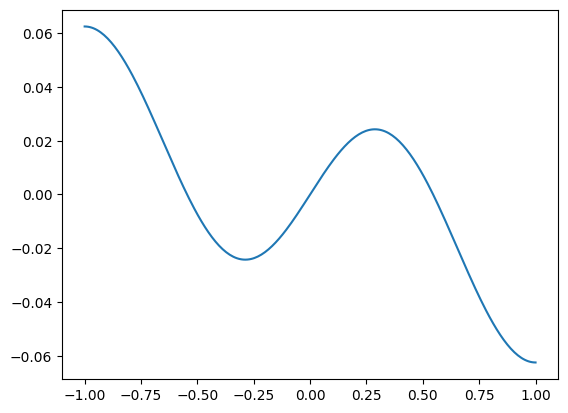

In [15]:
plt.plot(np.linspace(-1,1,len(vec_projected.real)), vec_projected.real)

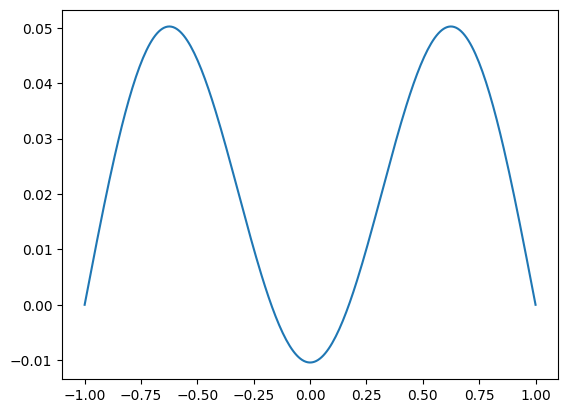

In [16]:
plt.plot(np.linspace(-1,1,len(vec_projected.imag)), vec_projected.imag)

# Chebyshev state preparation

Here we introduce the Chebyshev block encoding class and show how it can be used within LCUStatePreparationBox to implement simple linear combinations of Chebyshev polynomials.

In [17]:
import numpy as np
from pytket.extensions.qulacs import QulacsBackend
from pytket.circuit.display import render_circuit_jupyter
from matplotlib import pyplot as plt

from qtmlib.utils.linalg_utils import get_projector_matrix
from qtmlib.circuits.lcu_state_preparation.lcu_state_preparation_block_encoding import ChebychevBlockEncoding
from qtmlib.circuits.lcu_state_preparation.lcu_state_preparation import LCUStatePreparationBox

from numpy.polynomial import Chebyshev

We create a ChebyshevBlockEncoding for `n_qubits = 5` qubits. The method generate_basis_elements creates a RegisterBox implementing the Chebyshev polynomial of order `chebyshev_index` as a block encoding.

In [18]:
n_qubits = 5

W = ChebychevBlockEncoding(n_block_qubits=n_qubits)
W_box = W.generate_basis_element(basis_index=1)

We visualise the circuit.

In [19]:
render_circuit_jupyter(W_box.reg_circuit)

We create the first five Chebyshev basis elements and plot them. We also generate the exact Chebyshev polynomials.

In [20]:
def evaluate_block_encoding(anc_qubits, state_qubits, index=1):
    n_anc_qubits = len(anc_qubits)
    n_state_qubits = len(state_qubits)
    
    W_box = ChebychevBlockEncoding(n_block_qubits=n_state_qubits).generate_basis_element(basis_index=index)
    unitary = W_box.get_circuit().get_unitary()    
    
    # Compare to exact matrix
    projector = np.array(get_projector_matrix(list(range(n_anc_qubits)), list(range(n_anc_qubits, n_anc_qubits + n_state_qubits))))
    unitary_projected = projector.transpose() @ unitary @ projector
    
    # Compare to exact Chebyshev polynomial
    x_vals = np.linspace(-1,1,len(unitary_projected.diagonal()))
    coef = [0 for _ in range(index + 1)]
    coef[-1] = 1
    coef = tuple(coef)
    T = Chebyshev(coef=coef)
    y_vals = T(x_vals)
    
    return unitary_projected.diagonal().real, y_vals

In [21]:
anc_qubits = W_box.q_registers[0]
state_qubits = W_box.q_registers[1]

evaluations = []
for i in range(5):
    evaluations.append(evaluate_block_encoding(anc_qubits, state_qubits, i))
    

They agree up to numerical precision.

In [22]:
for eval in evaluations:
    print(np.linalg.norm(eval[0] - eval[1]))

0.0
7.523751499679691e-15
1.7641616131921784e-14
2.8179934834589785e-14
3.822887987796064e-14


Let's plot them.

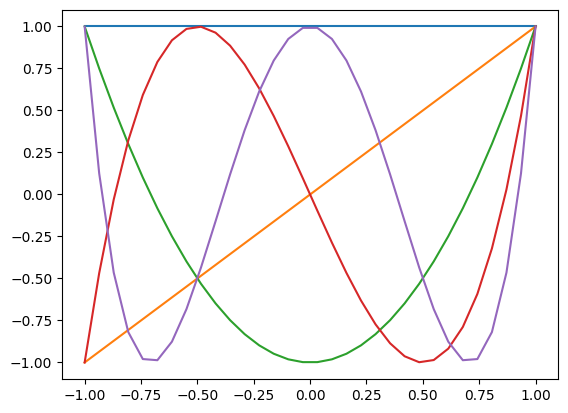

In [23]:
for eval in evaluations:
    plt.plot(np.linspace(-1,1,len(eval[0])), eval[0])

Looks good.

## Full state preparation circuit

Here we use the Chebyshev block encoding in combination with the LCUStatePreparationBox to prepare a simple linear combination of Chebyshev polynomials.

In [24]:
n_qubits = 8

W = ChebychevBlockEncoding(n_block_qubits=n_qubits)

dims_variables = (2**n_qubits,)

coeffs = np.zeros(4)
coeffs[1] = 0.5
coeffs[3] = 0.7

In [25]:
lcuspbox = LCUStatePreparationBox(
    coeffs,
    [W],
)

The circuit looks like...

In [26]:
render_circuit_jupyter(lcuspbox.reg_circuit)

We get the statevector from noiseless simulation and projecting to the all-zero state in the ancilla registers.

In [27]:
backend = QulacsBackend()
circ_compiled = backend.get_compiled_circuit(lcuspbox.get_circuit(), optimisation_level=0)
vec = backend.run_circuit(circ_compiled).get_state()

n_qubits_state = lcuspbox.n_qubits_state[0]
n_qubits_coeffs = lcuspbox.n_qubits_coeffs[0]
n_qubits_block_encoding = lcuspbox.n_qubits_block_encoding[0]

projector = np.array(get_projector_matrix(list(range(n_qubits_coeffs + n_qubits_block_encoding)), list(range(n_qubits_coeffs + n_qubits_block_encoding, n_qubits_coeffs + n_qubits_block_encoding + n_qubits_state))))
vec_projected = projector.transpose() @ vec

/Users/nathanfitzpatric/Github/qtmlib.worktrees/feature/select_unary_iteration/.venv/lib/python3.11/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/nathanfitzpatric/Github/qtmlib.worktrees/feature/select_unary_iteration/.venv/lib/python3.11/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


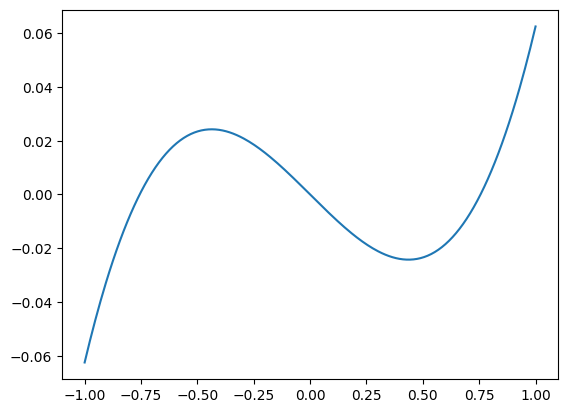

In [38]:
plt.plot(np.linspace(-1,1,len(vec_projected)), vec_projected)